In [8]:
import enspp.bma as bma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wrfpywind import data_preprocess as pp
import xarray as xr

In [2]:
# Path to data
datadir = '../data/'

In [3]:
# Specify the forecast initialization time
t_init = '2019-12-08'
t_init = pd.to_datetime(t_init)

In [4]:
# Read in the observational data
obs = pp.fmt_buoy_wspd(
                       data_path='/share/mzhang/jas983/wrf_data/oshwind/wrfpywind/wrfpywind/data/nyserda_buoy/', 
                       south_dates_str='20190904_20210207', north_dates_str='20190812_20210207', 
                       heights=[20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                       start_date='12-01-2019', end_date='12-31-2019')

Get and format the test data

In [5]:
# Read in and format the test data
t_end = t_init + pd.DateOffset(days=4)
test_data = bma.get_fmt_df(obs, t_init, t_end, datadir=datadir, type='test')

Get and format the training data for `n_days` of data

In [6]:
mean_crps = np.zeros(7)
# Decide how many days of data you would like to use
for ii, n_days in enumerate(range(1,8)):

    # Find the first training day
    d1_training = t_init - pd.DateOffset(days=n_days)

    # Specify the start dates  
    start_dates = pd.date_range(d1_training, periods=n_days)

    # Specify the end dates by specifying how long these simlulations should last
    end_dates = start_dates + pd.DateOffset(days=4)

    for ii in range(0,len(start_dates)):
        # Read in an format the training data
        train_data_new = bma.get_fmt_df(obs, start_dates[ii], end_dates[ii], datadir=datadir, type='train')

        if ii == 0:
            # Create the train_data DataFrame
            train_data = train_data_new
        else:
            # Concat the new data into the same training DataFrame 
            train_data = pd.concat([train_data, train_data_new], axis=0)

    # Finally remove any data from after the WRF initialization time
    train_data = train_data[train_data['Time'] < t_init]

    # And reset the index
    train_data = train_data.reset_index(drop=True)

    # Fit the BMA parameters
    fit = bma.get_bma_fit(train_data)

    # Calculate the CRPS
    crps = bma.get_crps(fit, test_data, n_ens_members=5, gamma_bma=None)
    # To determine the optimal amount of training data, I will use the mean CRPS
    mean_crps[ii] = np.mean(crps)

In [7]:
print(mean_crps)

[1.62424644 1.56566162 1.58006537 1.57401996 1.60138528 1.6147223
 1.6313323 ]


Text(0, 0.5, 'Average CRPS')

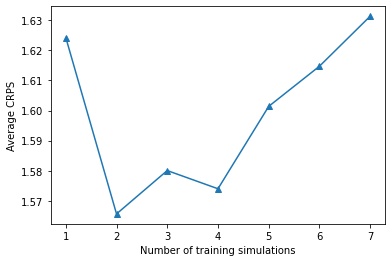

In [15]:
plt.plot(range(1,8), mean_crps, marker='^')
plt.xlabel('Number of training simulations')
plt.ylabel('Average CRPS')
plt.show()